In [11]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
import seaborn as sns
import numpy as np

from metadata.etfs import etfs_large, etfs_small
from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [12]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
results_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs", "results")

des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam", "dynotears"]
metric_names = ["stability", "mse", "mae", "mse_crisis", "mae_crisis"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [13]:
warnings.simplefilter("ignore")


all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if (etf_focus != etf) and (etf_focus is not None):
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions']
        predictions_covid_df = predictions_df.loc["2020-01-01":"2021-01-01"]
        predictions_gfc_df = predictions_df.loc["2007-06-01":"2008-06-01"]
        crisis_predictions = [predictions_covid_df, predictions_gfc_df]

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling mse
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"]).pow(2).rolling(12).mean()
        rolling_metric_df["rolling_mse"] = rolling_metric_df["rolling_var"] + rolling_metric_df["rolling_bias"] * 100
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["rolling_mse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"]) * 100
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"]) * 100

        crisis_mse = []
        crisis_mae = []
        for tmp_pred in crisis_predictions:
            tmp_mse = mean_squared_error(tmp_pred["true"], tmp_pred["prediction"])
            tmp_mae = mean_absolute_error(tmp_pred["true"], tmp_pred["prediction"])

            crisis_mse.append(tmp_mse)
            crisis_mae.append(tmp_mae)
        crisis_mse = np.mean(crisis_mse) * 100
        crisis_mae = np.mean(crisis_mae) * 100

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # save parents
        parents_of_target_df["fs"] = fs
        parents_of_target_df["etf"] = etf
        
        tot = len(parents_of_target_df["date"].unique())
        stability_df = (parents_of_target_df.fillna(0).groupby(["cluster"]).sum()[["value"]] / tot).sort_values(by="value", ascending=False)
        stability_df = pd.concat({etf: stability_df}, names=['etf'])
        stability.append(stability_df)

        stability_measure = (stability_df).sum().iloc[0] / stability_df.shape[0]
        metrics_df = pd.DataFrame({
            "fs": fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            # "bias": [bias],
            # "var": [var],
            "mse_crisis": [crisis_mse], 
            "mae_crisis": [crisis_mae],
            "stability": stability_measure})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
        all_parents.append(parents_of_target_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
    all_stability.append(pd.concat(stability))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

## Boxplots with summary statistics

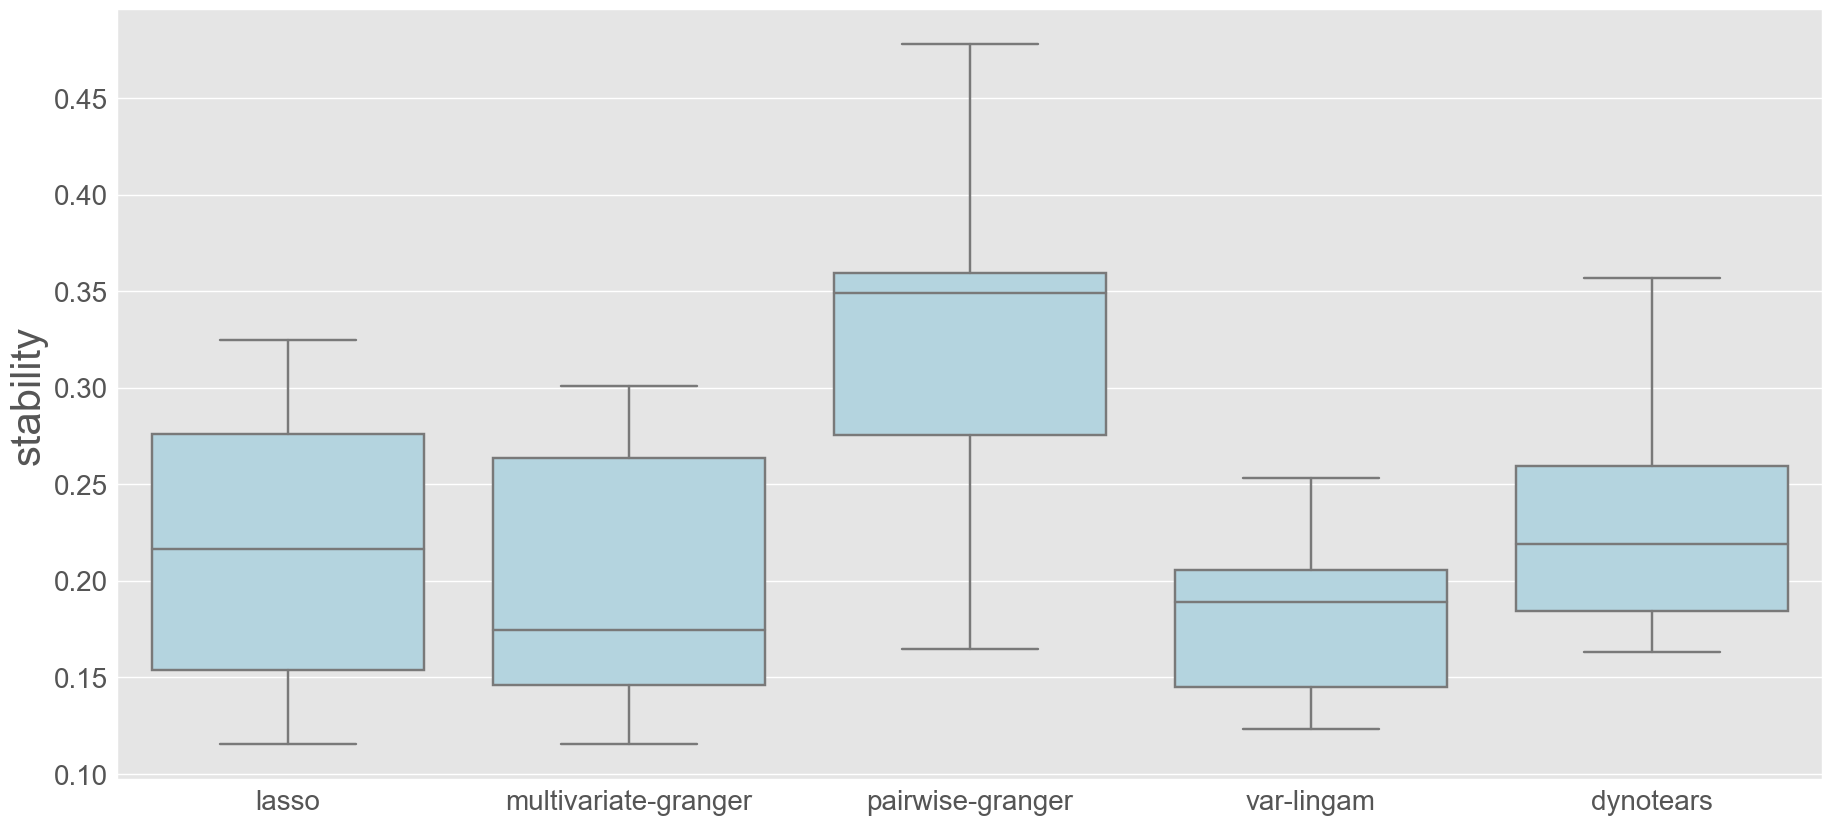

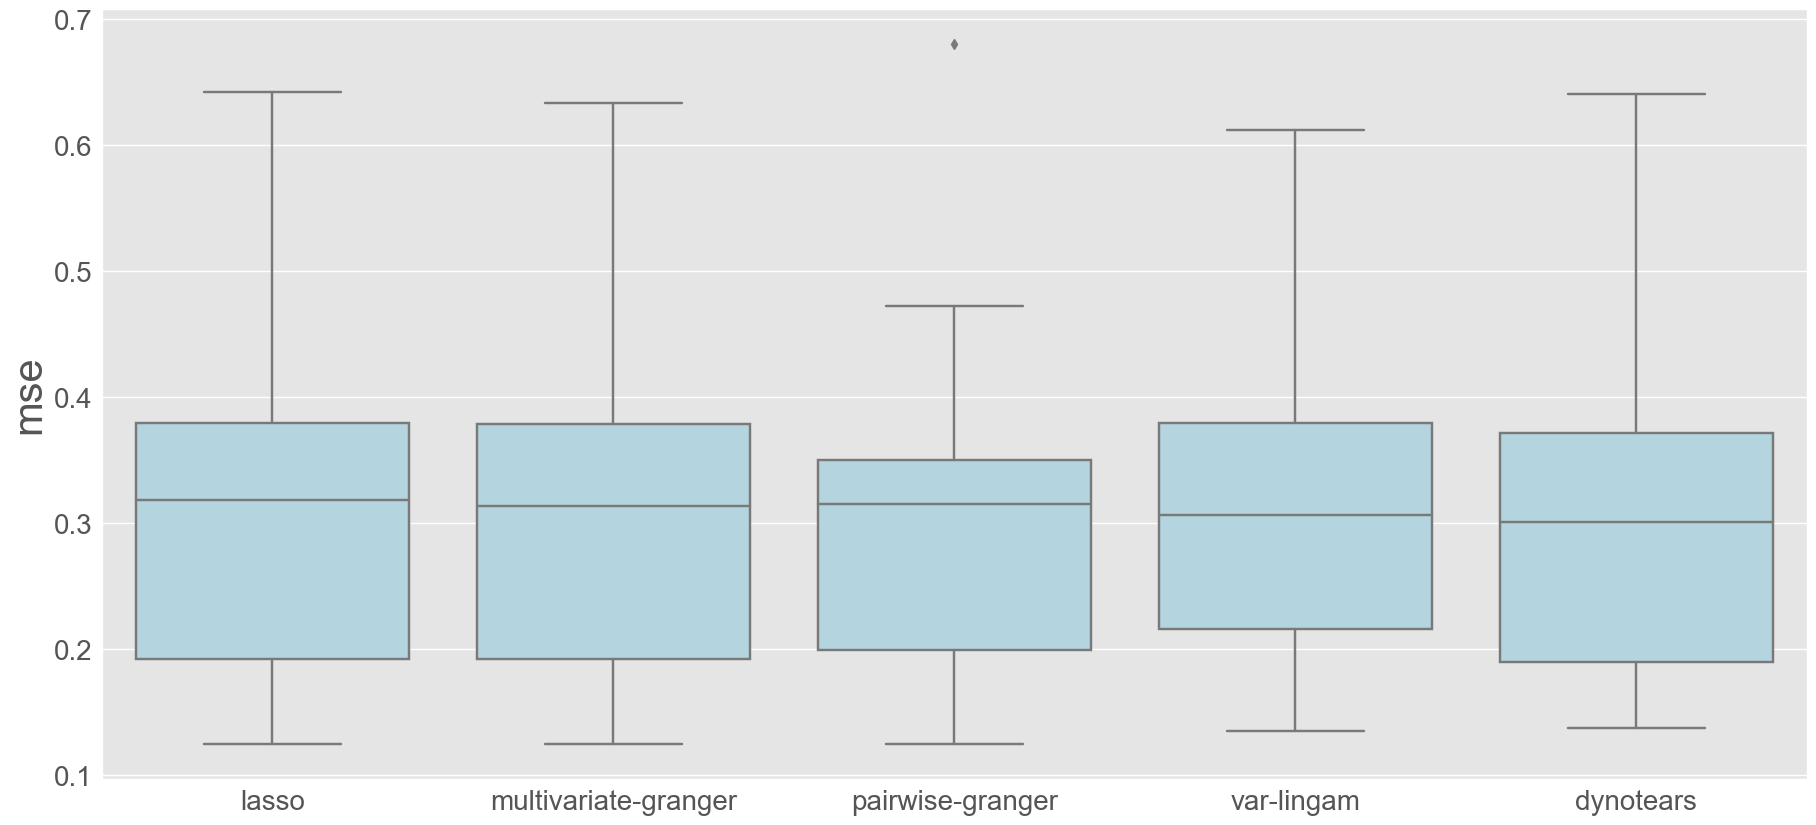

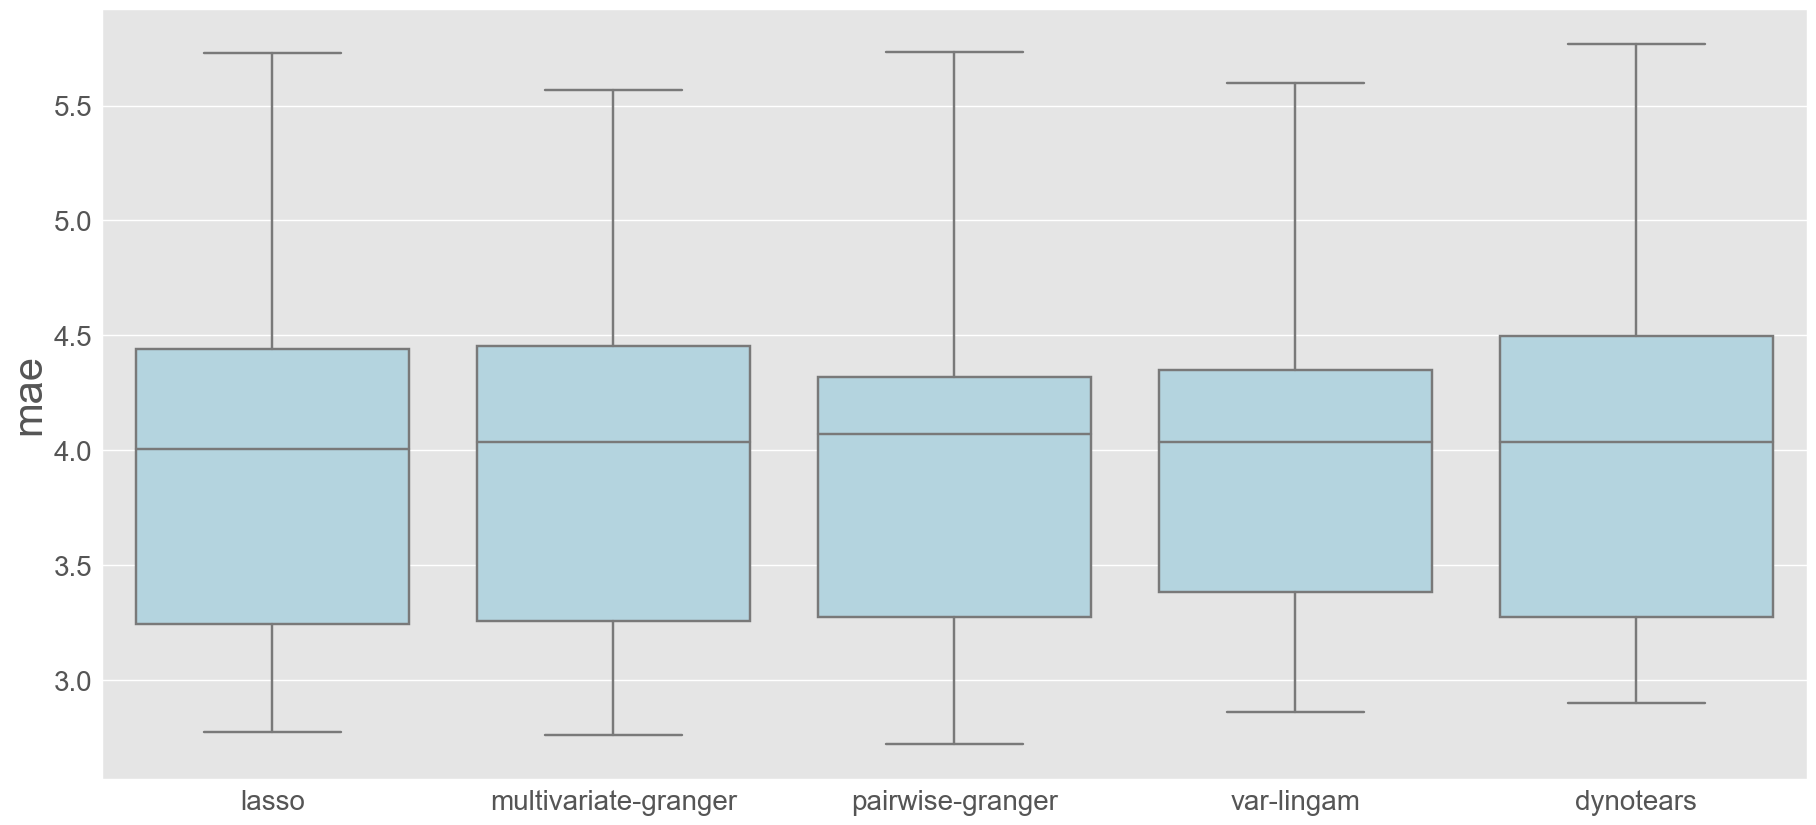

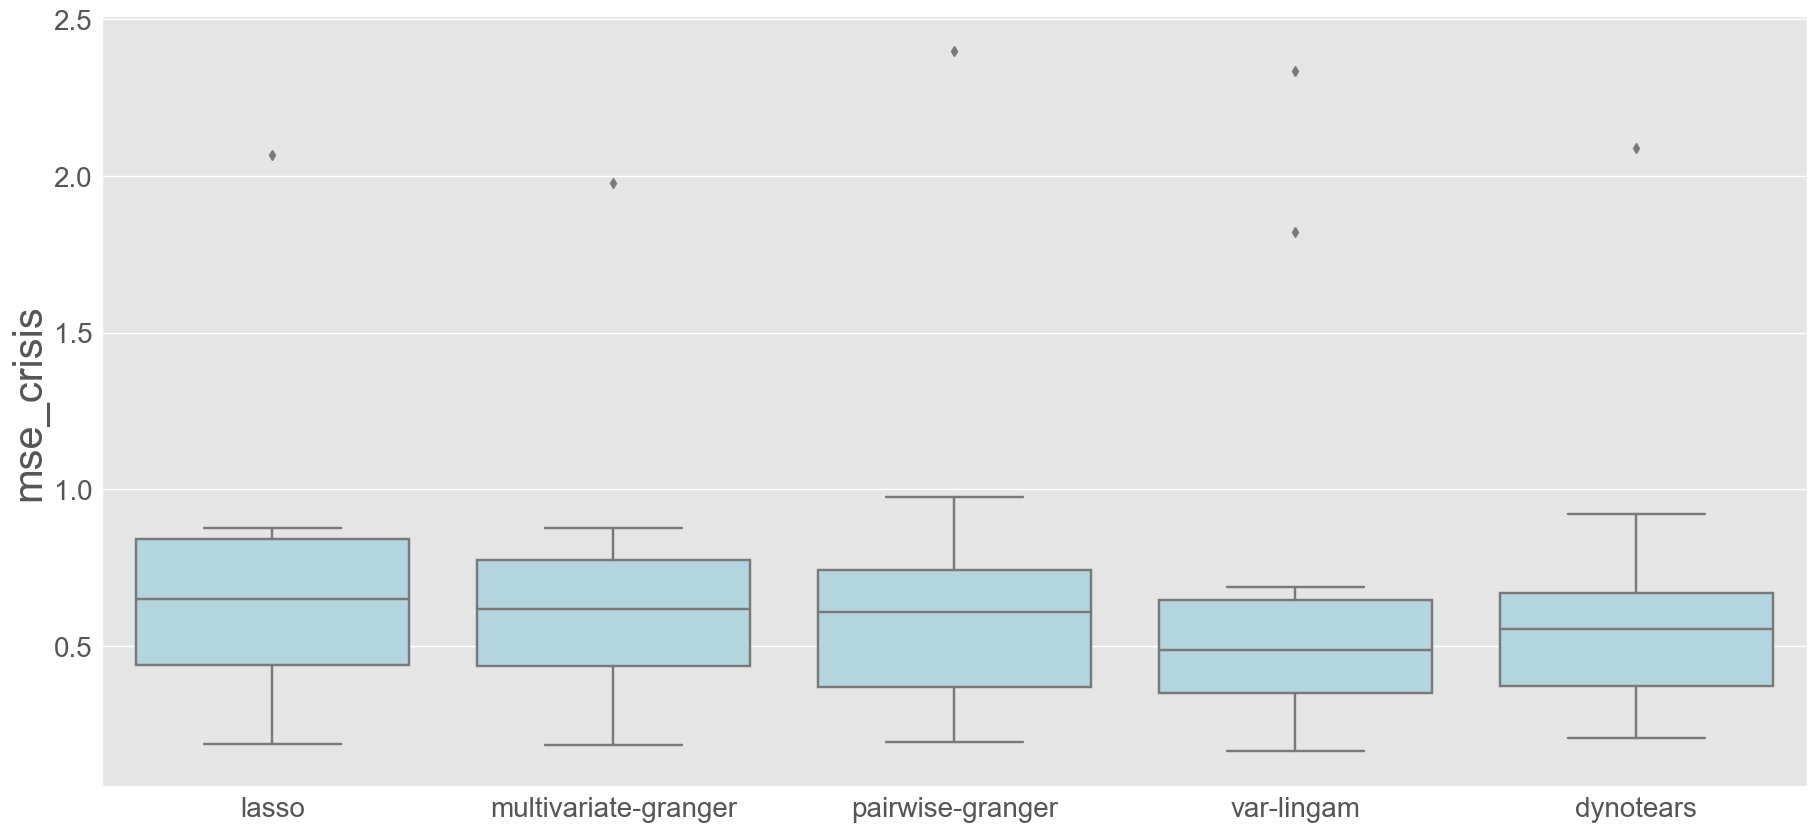

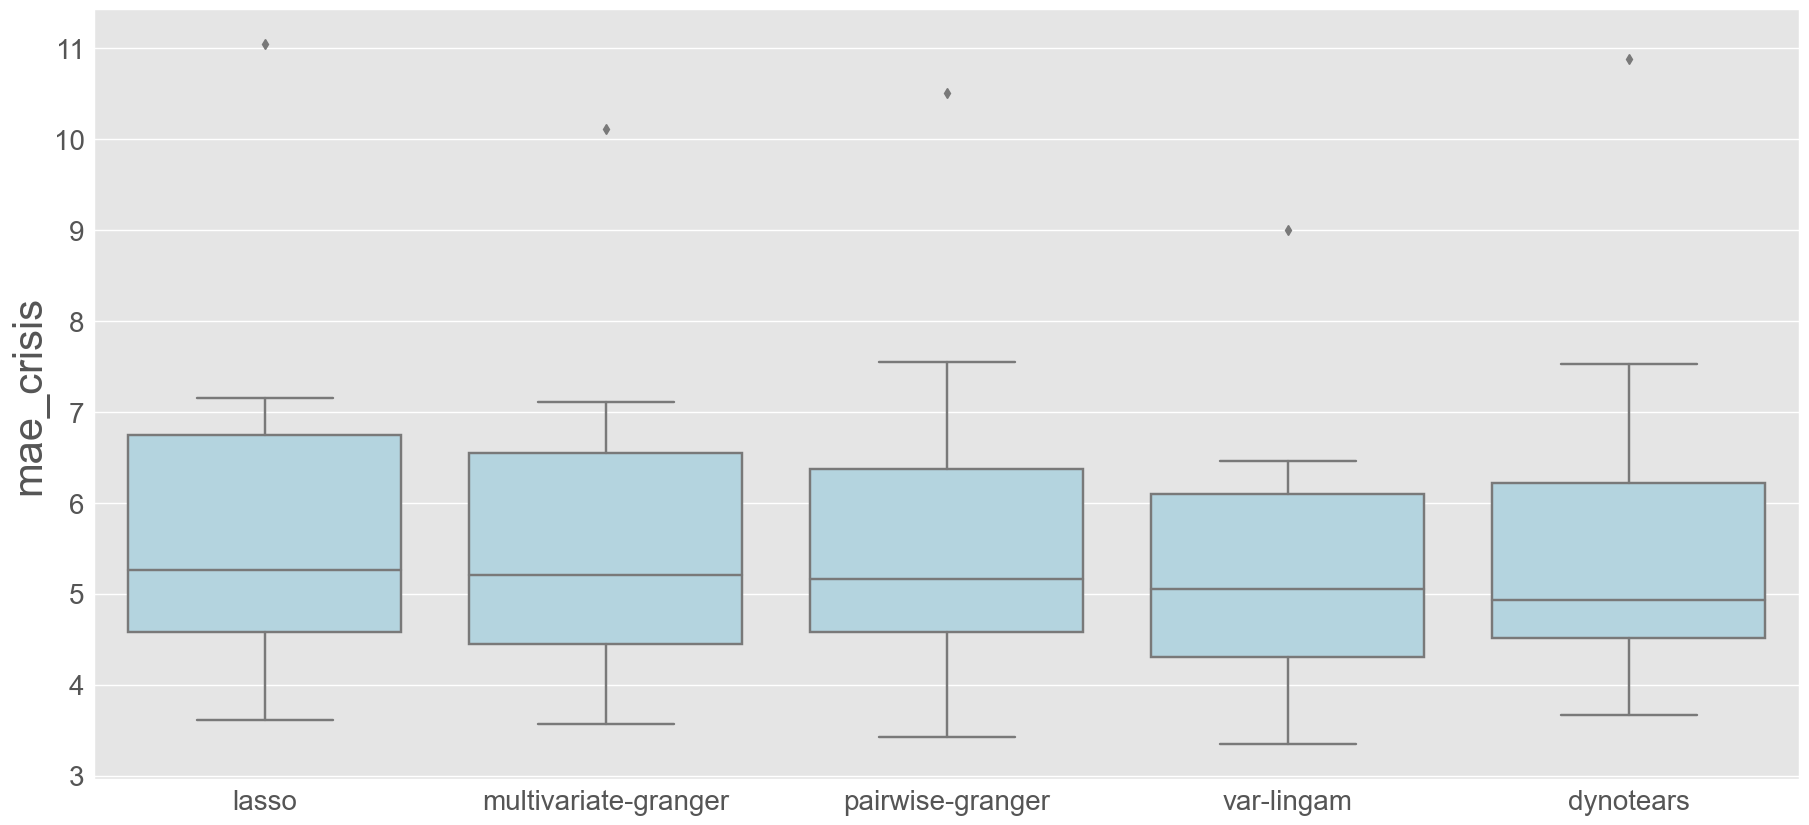

In [14]:
metric_name = "mse"
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("", fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=15)
    fig.savefig(os.path.join(results_path, f'boxplot_agg_{m}_fs.png'))

### Prediction error over time

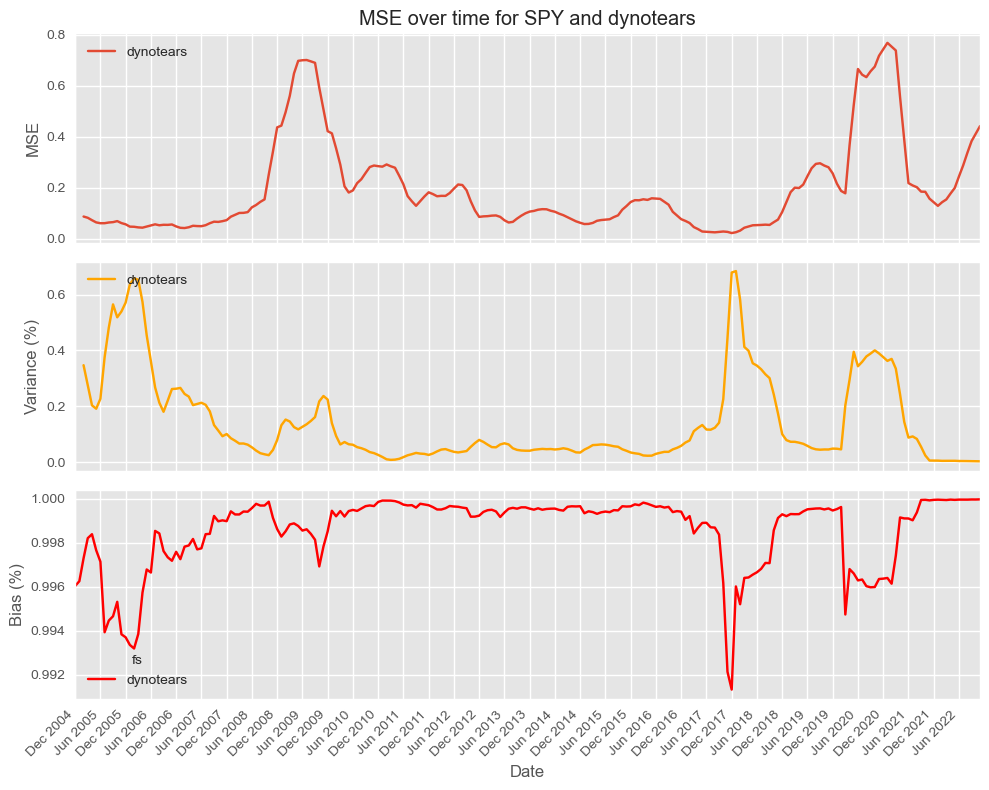

In [15]:
etf = "SPY"
fs = "dynotears"

# mse
etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
etf_rolling_metrics_df["diff_lasso_var-lingam"] = 1

# variance
etf_rolling_variance_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_var")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel()
etf_rolling_variance_df = etf_rolling_variance_df.rolling(3).mean()
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel(1) 

# bias
etf_rolling_bias_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_bias")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel()
etf_rolling_biass_df = etf_rolling_bias_df.rolling(3).mean()
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel(1) 

# plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# plotting on the upper subplot
etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
axs[0].set_title(f'MSE over time for {etf} and {fs}')
axs[0].set_ylabel('MSE')
axs[0].legend(loc='upper left')

# plotting on the upper subplot
etf_rolling_variance_df.plot(ax=axs[1], color="orange")
# axs[1].set_title(f'Variance over time for {etf}')
axs[1].set_ylabel('Variance (%)')
axs[1].legend(loc='upper left')

# plotting on the lower subplot
etf_rolling_bias_df.plot(ax=axs[2], color="red")
# axs[2].set_title(f'Bias over time for {etf}')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Bias (%)')

# adding months and years to the index of the plot
tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
axs[2].set_xticks(tick_positions)
axs[2].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

# adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

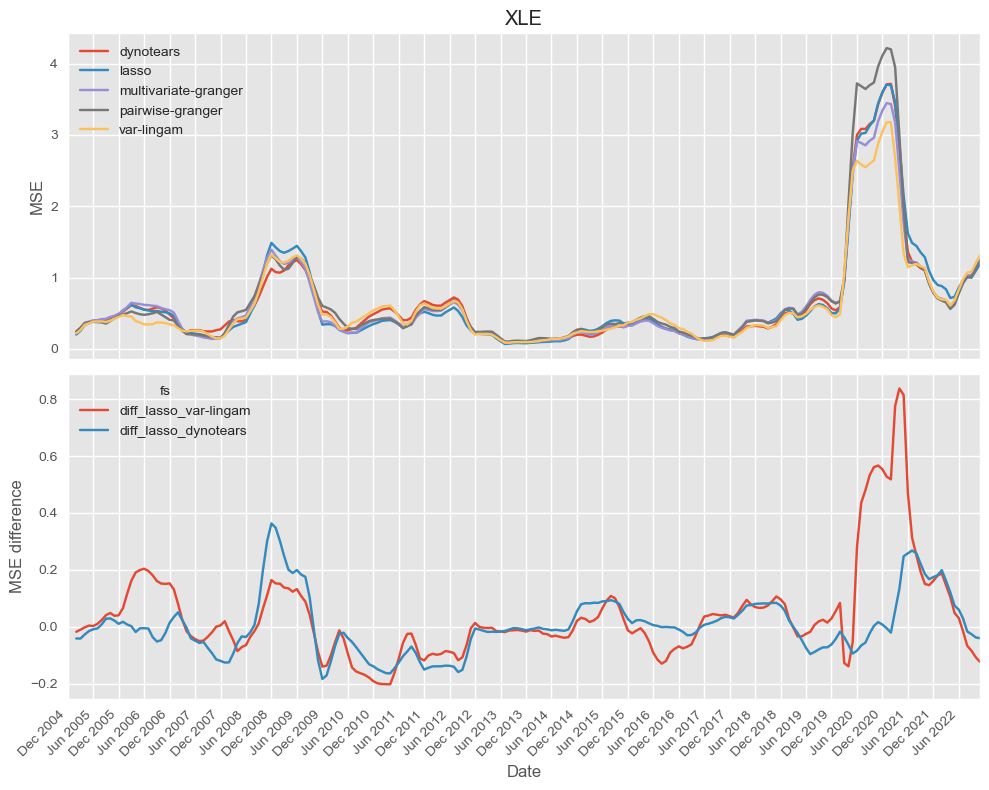

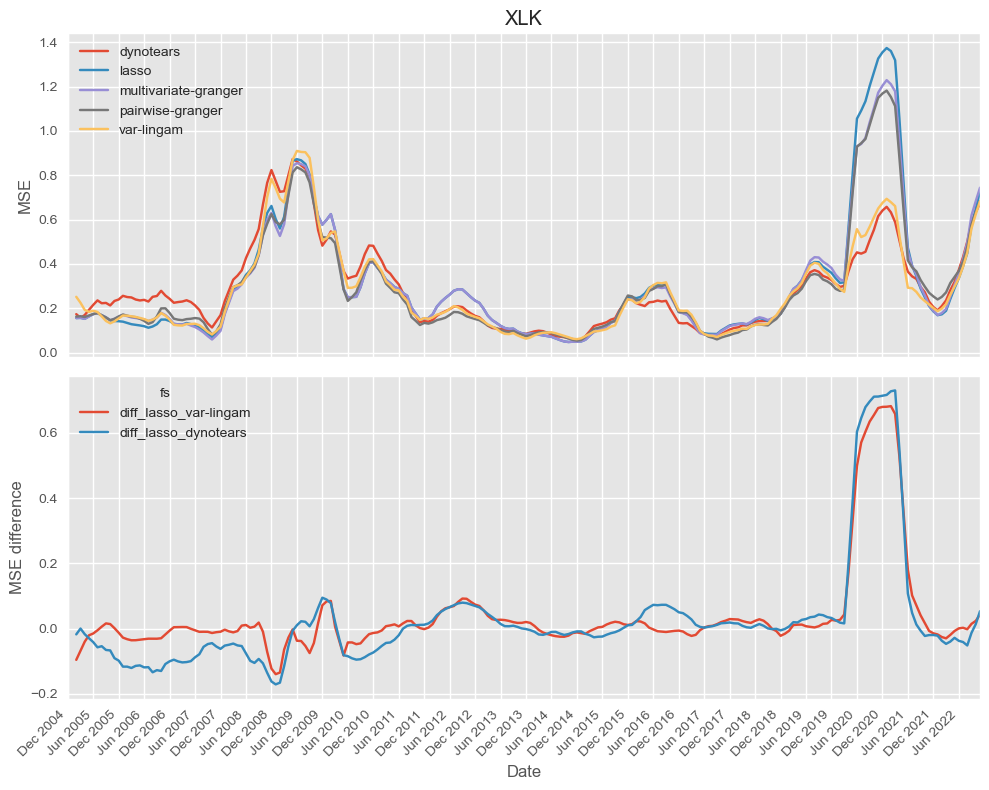

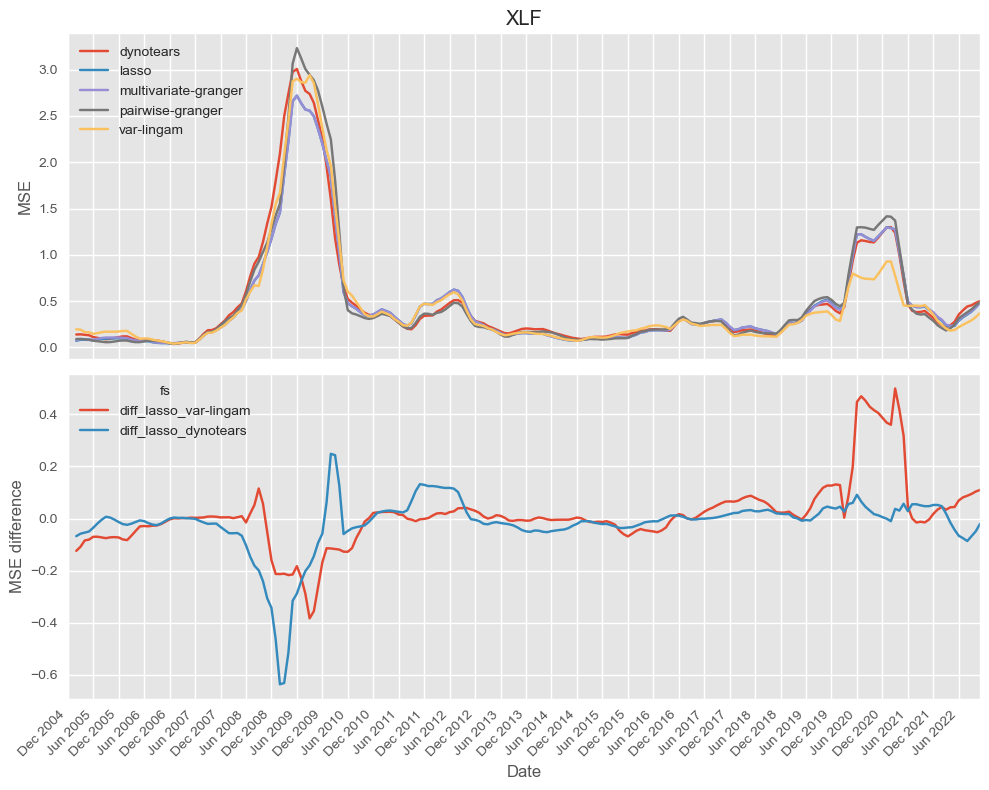

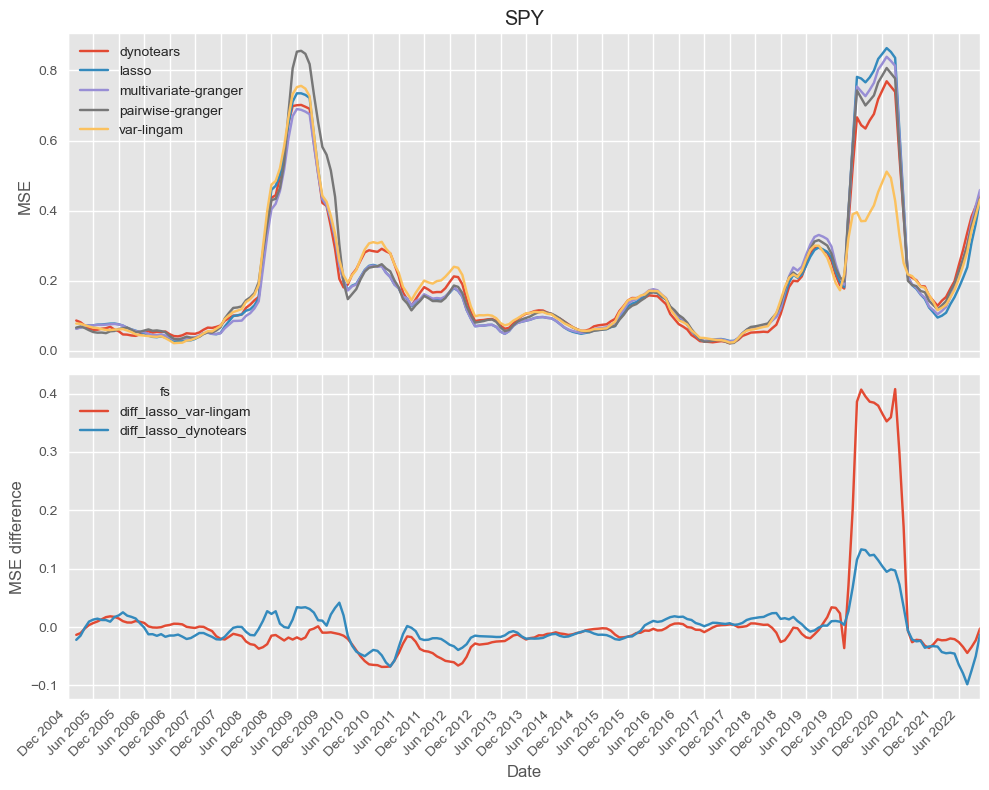

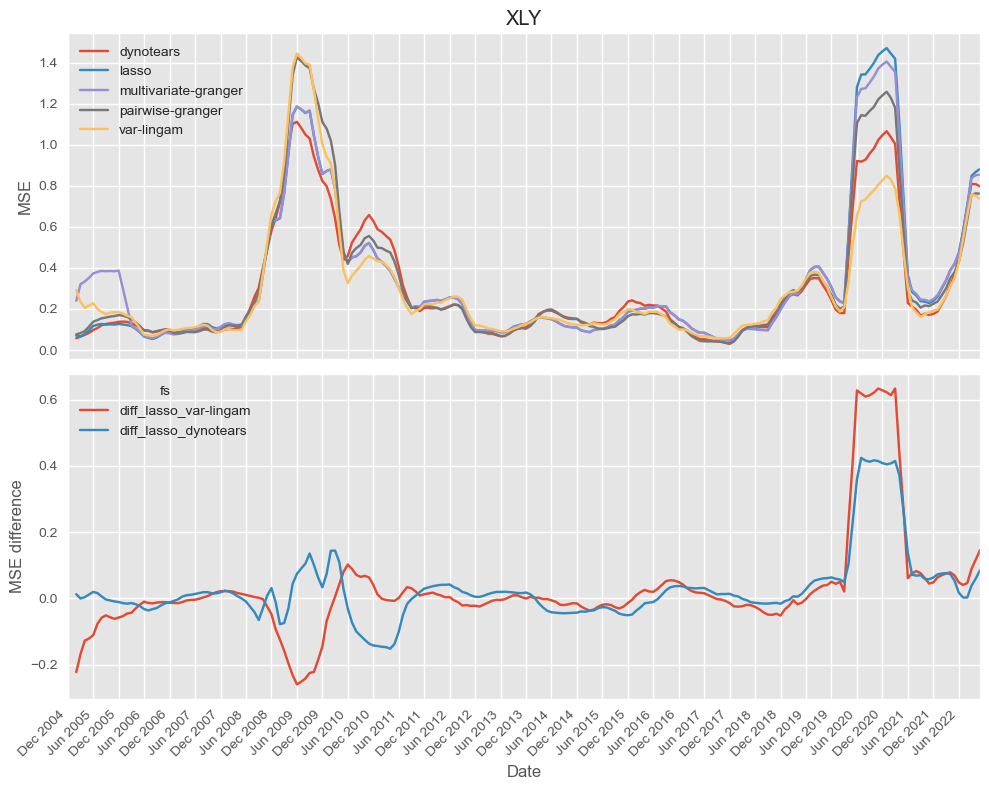

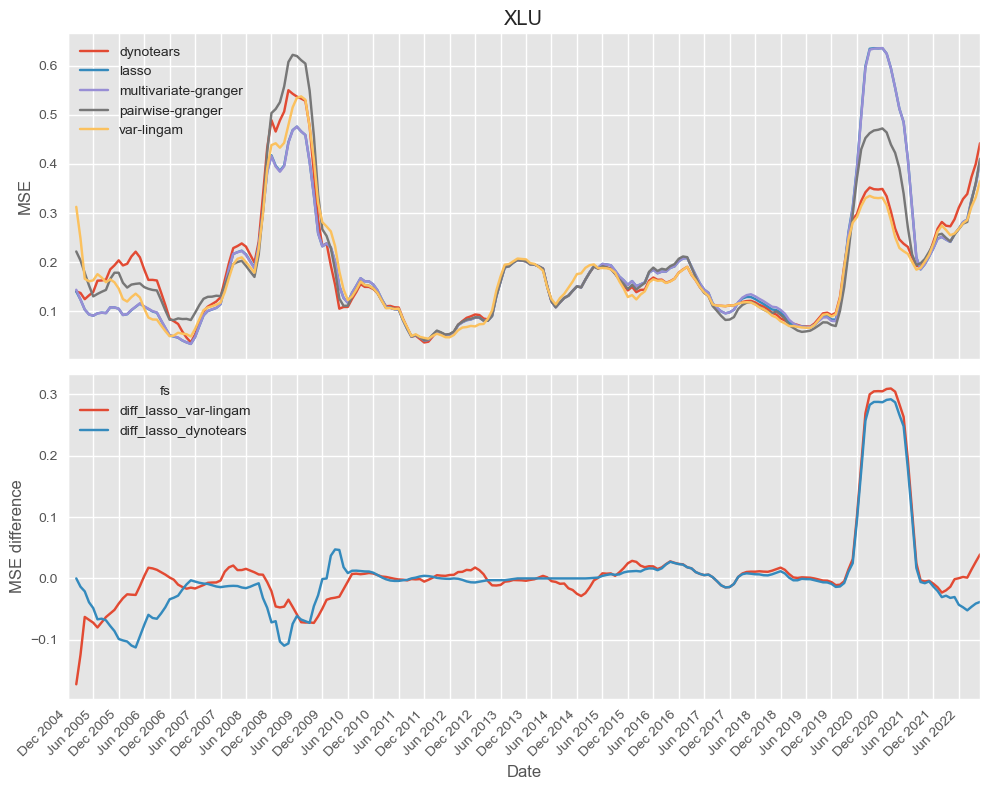

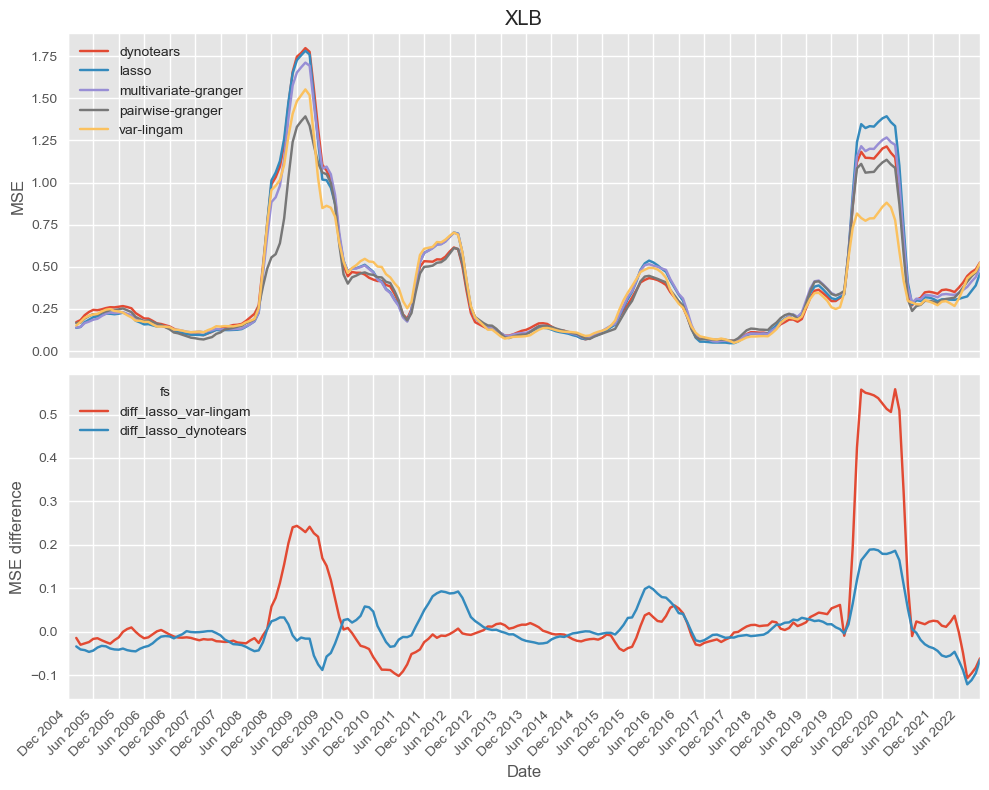

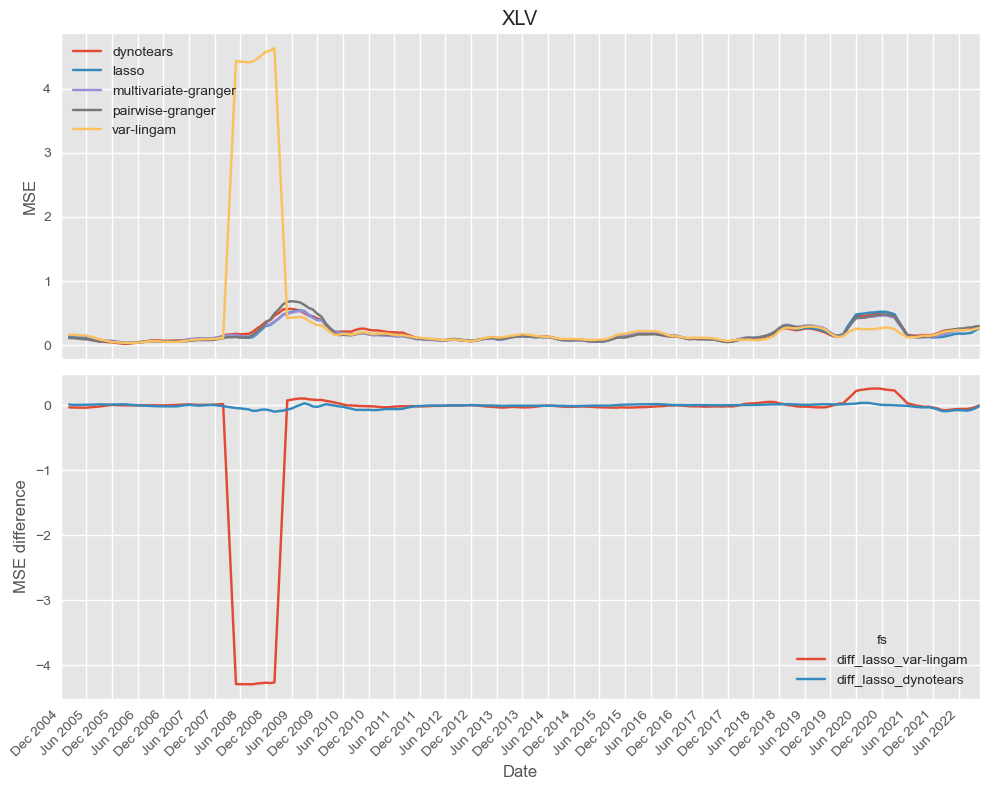

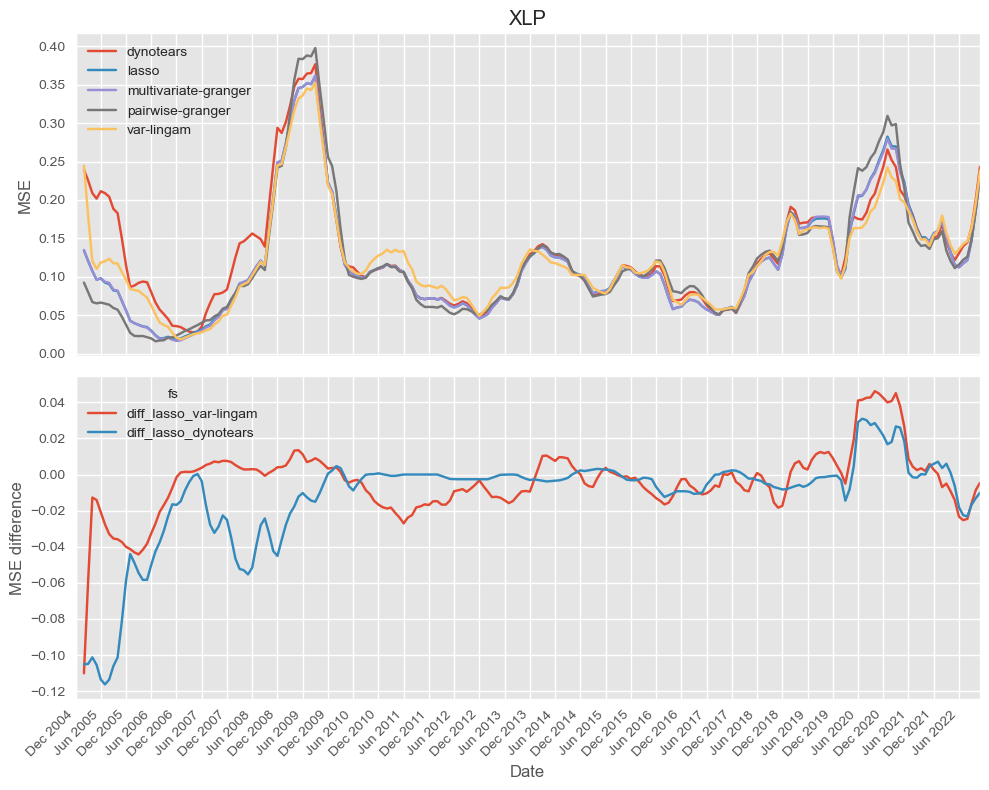

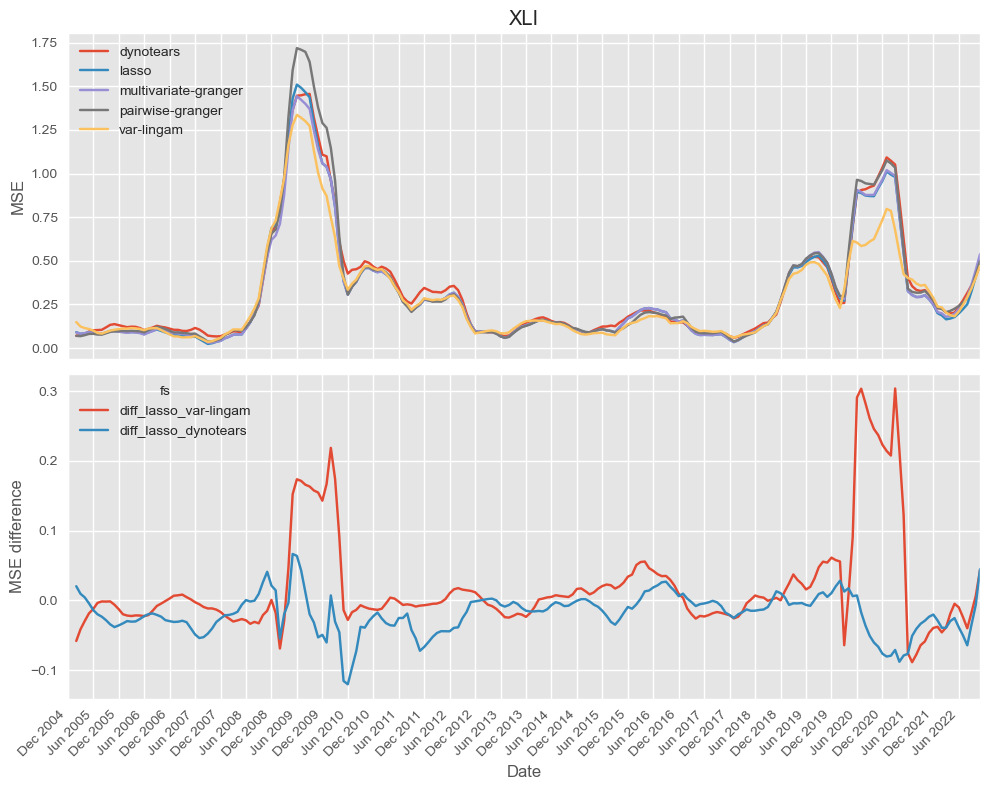

In [25]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["var-lingam"]
    etf_rolling_metrics_df["diff_lasso_dynotears"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["dynotears"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam", "diff_lasso_dynotears"], axis=1).plot(ax=axs[0])
    # etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'{etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df[["diff_lasso_var-lingam", "diff_lasso_dynotears"]].plot(ax=axs[1])
    # etf_rolling_metrics_df[["diff_lasso_var-lingam"]].plot(ax=axs[1])
    # axs[1].set_title(f'MSE difference between lasso and a causal model for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # export plot
    fig.savefig(os.path.join(results_path, f'{etf}_rolling_mse.png'))

    # Show the plot
    plt.show()

## Selected parents over time

In [17]:
etf = "SPY"
fss = ["var-lingam", "multivariate-granger"]

In [18]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[0]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

value                                                         \
etf               SPY                                                          
fs         var-lingam                                                          
cluster          0.0  4.0  6.0  7.0  8.0  9.0  10.0 12.0 13.0 15.0 16.0 18.0   
date                                                                           
2020-01-31        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN   
2020-02-29        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN   
2020-04-30        NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                 
etf              
fs               
cluster    19.0  
date             
2020-01-31  NaN  
2020-02-29  NaN  
2020-04-30  NaN

In [19]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[1]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

value                                               \
etf                         SPY                                                
fs         multivariate-granger                                                
cluster                    0.0  1.0  2.0  8.0  9.0  10.0 12.0 14.0 15.0 16.0   
date                                                                           
2020-01-31                  NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  1.0  1.0   
2020-02-29                  NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  1.0  1.0   
2020-03-31                  NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  1.0  1.0   
2020-04-30                  NaN  NaN  1.0  NaN  1.0  NaN  NaN  NaN  NaN  1.0   

                 
etf              
fs               
cluster    17.0  
date             
2020-01-31  NaN  
2020-02-29  NaN  
2020-03-31  1.0  
2020-04-30  NaN

## Table of summary statistics

In [20]:
etf = "XLP"

all_metrics_df[all_metrics_df.index.isin([etf], level=1)].sort_values(by="mse", ascending=True)

,,mse,mae,mse_crisis,mae_crisis,stability
fs,etf,,,,,
lasso,XLP,0.124668,2.774852,0.186667,3.608098,0.128938
multivariate-granger,XLP,0.124681,2.761493,0.185152,3.562969,0.115285
pairwise-granger,XLP,0.124826,2.721580,0.194752,3.426823,0.261209
var-lingam,XLP,0.135277,2.862635,0.164592,3.345697,0.214286
dynotears,XLP,0.137273,2.899090,0.205224,3.671474,0.162806


In [21]:
all_metrics_df.sort_values(by=["mse"], ascending=True)

,,mse,mae,mse_crisis,mae_crisis,stability
fs,etf,,,,,
lasso,XLP,0.124668,2.774852,0.186667,3.608098,0.128938
multivariate-granger,XLP,0.124681,2.761493,0.185152,3.562969,0.115285
pairwise-granger,XLP,0.124826,2.721580,0.194752,3.426823,0.261209
var-lingam,XLP,0.135277,2.862635,0.164592,3.345697,0.214286
dynotears,XLP,0.137273,2.899090,0.205224,3.671474,0.162806
lasso,XLV,0.174747,3.219215,0.328295,4.518101,0.209393
multivariate-granger,XLV,0.176579,3.230642,0.309451,4.404096,0.175737
pairwise-granger,XLV,0.179800,3.212934,0.303338,4.215854,0.477974
dynotears,XLV,0.179923,3.264908,0.350803,4.742649,0.261674


In [22]:
all_metrics_df.sort_values(by="mae", ascending=True)

mse       mae  mse_crisis  mae_crisis  \
fs                   etf                                               
pairwise-granger     XLP  0.124826  2.721580    0.194752    3.426823   
multivariate-granger XLP  0.124681  2.761493    0.185152    3.562969   
lasso                XLP  0.124668  2.774852    0.186667    3.608098   
var-lingam           XLP  0.135277  2.862635    0.164592    3.345697   
dynotears            XLP  0.137273  2.899090    0.205224    3.671474   
                     SPY  0.198676  3.206690    0.436351    4.441774   
pairwise-granger     XLV  0.179800  3.212934    0.303338    4.215854   
lasso                XLV  0.174747  3.219215    0.328295    4.518101   
                     SPY  0.198966  3.227080    0.480108    4.686416   
multivariate-granger XLV  0.176579  3.230642    0.309451    4.404096   
pairwise-granger     SPY  0.205601  3.233393    0.465870    4.498485   
multivariate-granger SPY  0.198270  3.235971    0.458092    4.409160   
dynotears            XLV  0.179923  3.264908    0.350803    4.742649   
var-lingam           SPY  0.191977  3.269239    0.316563    4.241058   
dynotears            XLU  0.186579  3.298847    0.294644    4.306147   
lasso                XLU  0.189962  3.303822    0.427425    5.000492   
multivariate-granger XLU  0.190624  3.315943    0.426801    5.010242   
var-lingam           XLU  0.186802  3.375667    0.268292    4.105654   
pairwise-granger     XLU  0.197236  3.398602    0.336529    4.804573   
var-lingam           XLV  0.386429  3.407943    2.332578    6.455363   
lasso                XLI  0.315201  3.943843    0.533778    4.542435   
dynotears            XLY  0.305299  3.957805    0.593508    4.992367   
multivariate-granger XLI  0.313608  3.964045    0.537476    4.566708   
var-lingam           XLI  0.296216  3.964069    0.444825    4.482225   
pairwise-granger     XLY  0.328646  4.067103    0.695231    5.507836   
lasso                XLY  0.335481  4.067441    0.788932    5.650123   
pairwise-granger     XLI  0.328836  4.070806    0.575765    4.946952   
multivariate-granger XLY  0.344520  4.104054    0.763602    5.667972   
var-lingam           XLY  0.316494  4.108884    0.472830    4.759882   
dynotears            XLI  0.325673  4.114304    0.573598    4.860807   
var-lingam           XLK  0.288494  4.136998    0.503922    5.471336   
pairwise-granger     XLK  0.301919  4.137620    0.756861    6.658323   
multivariate-granger XLK  0.313915  4.233352    0.779601    6.833313   
lasso                XLK  0.321273  4.274904    0.859442    7.154802   
dynotears            XLK  0.296685  4.342874    0.532052    6.443604   
pairwise-granger     XLB  0.356857  4.379097    0.644272    5.375638   
var-lingam           XLB  0.359152  4.418625    0.523993    5.347234   
lasso                XLB  0.394618  4.496441    0.764000    5.520736   
multivariate-granger XLB  0.390080  4.526143    0.698930    5.403767   
dynotears            XLB  0.387007  4.548677    0.695613    5.521603   
pairwise-granger     XLF  0.472143  4.749009    0.974814    7.547643   
var-lingam           XLF  0.443117  4.751806    0.689382    6.301851   
lasso                XLF  0.451545  4.783538    0.877284    7.107452   
multivariate-granger XLF  0.452176  4.801156    0.877284    7.107452   
dynotears            XLF  0.471459  4.929917    0.922661    7.522781   
multivariate-granger XLE  0.633621  5.565830    1.976295   10.102793   
var-lingam           XLE  0.612042  5.598053    1.819014    8.993113   
lasso                XLE  0.642209  5.730279    2.067236   11.039428   
pairwise-granger     XLE  0.680366  5.734726    2.397466   10.502663   
dynotears            XLE  0.640767  5.767103    2.087819   10.879341   

                          stability  
fs                   etf             
pairwise-granger     XLP   0.261209  
multivariate-granger XLP   0.115285  
lasso                XLP   0.128938  
var-lingam           XLP   0.214286  
dynotears            XLP   0.162806  
                    

In [23]:
all_metrics_df.sort_values(by="stability", ascending=False)

mse       mae  mse_crisis  mae_crisis  \
fs                   etf                                               
pairwise-granger     XLV  0.179800  3.212934    0.303338    4.215854   
                     XLB  0.356857  4.379097    0.644272    5.375638   
                     XLE  0.680366  5.734726    2.397466   10.502663   
dynotears            SPY  0.198676  3.206690    0.436351    4.441774   
pairwise-granger     SPY  0.205601  3.233393    0.465870    4.498485   
                     XLF  0.472143  4.749009    0.974814    7.547643   
                     XLK  0.301919  4.137620    0.756861    6.658323   
lasso                SPY  0.198966  3.227080    0.480108    4.686416   
dynotears            XLK  0.296685  4.342874    0.532052    6.443604   
pairwise-granger     XLY  0.328646  4.067103    0.695231    5.507836   
lasso                XLK  0.321273  4.274904    0.859442    7.154802   
multivariate-granger XLK  0.313915  4.233352    0.779601    6.833313   
lasso                XLY  0.335481  4.067441    0.788932    5.650123   
multivariate-granger SPY  0.198270  3.235971    0.458092    4.409160   
                     XLY  0.344520  4.104054    0.763602    5.667972   
lasso                XLB  0.394618  4.496441    0.764000    5.520736   
dynotears            XLV  0.179923  3.264908    0.350803    4.742649   
pairwise-granger     XLP  0.124826  2.721580    0.194752    3.426823   
dynotears            XLU  0.186579  3.298847    0.294644    4.306147   
var-lingam           XLE  0.612042  5.598053    1.819014    8.993113   
dynotears            XLB  0.387007  4.548677    0.695613    5.521603   
multivariate-granger XLB  0.390080  4.526143    0.698930    5.403767   
pairwise-granger     XLI  0.328836  4.070806    0.575765    4.946952   
lasso                XLE  0.642209  5.730279    2.067236   11.039428   
var-lingam           XLP  0.135277  2.862635    0.164592    3.345697   
lasso                XLV  0.174747  3.219215    0.328295    4.518101   
var-lingam           XLV  0.386429  3.407943    2.332578    6.455363   
dynotears            XLI  0.325673  4.114304    0.573598    4.860807   
var-lingam           XLF  0.443117  4.751806    0.689382    6.301851   
                     XLK  0.288494  4.136998    0.503922    5.471336   
                     XLU  0.186802  3.375667    0.268292    4.105654   
dynotears            XLE  0.640767  5.767103    2.087819   10.879341   
                     XLY  0.305299  3.957805    0.593508    4.992367   
multivariate-granger XLV  0.176579  3.230642    0.309451    4.404096   
                     XLE  0.633621  5.565830    1.976295   10.102793   
dynotears            XLF  0.471459  4.929917    0.922661    7.522781   
lasso                XLI  0.315201  3.943843    0.533778    4.542435   
pairwise-granger     XLU  0.197236  3.398602    0.336529    4.804573   
dynotears            XLP  0.137273  2.899090    0.205224    3.671474   
multivariate-granger XLI  0.313608  3.964045    0.537476    4.566708   
lasso                XLF  0.451545  4.783538    0.877284    7.107452   
var-lingam           XLB  0.359152  4.418625    0.523993    5.347234   
                     XLY  0.316494  4.108884    0.472830    4.759882   
multivariate-granger XLF  0.452176  4.801156    0.877284    7.107452   
var-lingam           XLI  0.296216  3.964069    0.444825    4.482225   
lasso                XLP  0.124668  2.774852    0.186667    3.608098   
var-lingam           SPY  0.191977  3.269239    0.316563    4.241058   
multivariate-granger XLU  0.190624  3.315943    0.426801    5.010242   
lasso                XLU  0.189962  3.303822    0.427425    5.000492   
multivariate-granger XLP  0.124681  2.761493    0.185152    3.562969   

                          stability  
fs                   etf             
pairwise-granger     XLV   0.477974  
                     XLB   0.411294  
                     XLE   0.360289  
dynotears            SPY   0.356667  
pairwise-granger     SPY   0.355727  
                    

In [24]:
all_metrics_df.sort_values(by="mse_2020", ascending=True)

KeyError: 'mse_2020'

In [ ]:
all_metrics_df.sort_values(by="mse", ascending=True)

,,mse,mae,mse_2020,mae_2020,stability
fs,etf,,,,,
lasso,XLP,0.124668,2.774852,0.002990,0.047255,0.128938
multivariate-granger,XLP,0.124681,2.761493,0.002961,0.046559,0.115285
pairwise-granger,XLP,0.124826,2.721580,0.003229,0.044722,0.261209
var-lingam,XLP,0.135277,2.862635,0.002533,0.041580,0.214286
dynotears,XLP,0.137273,2.899090,0.002787,0.044311,0.162806
lasso,XLV,0.174747,3.219215,0.005626,0.059463,0.209393
multivariate-granger,XLV,0.176579,3.230642,0.005062,0.056096,0.175737
pairwise-granger,XLV,0.179800,3.212934,0.005204,0.058207,0.477974
dynotears,XLV,0.179923,3.264908,0.005567,0.059978,0.261674


<AxesSubplot:xlabel='stability', ylabel='mae'>

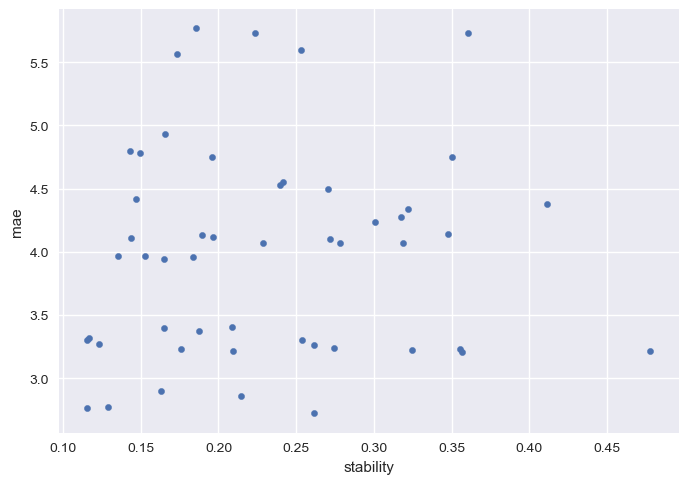

In [ ]:
all_metrics_df.plot.scatter(y="mae", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mae_2020'>

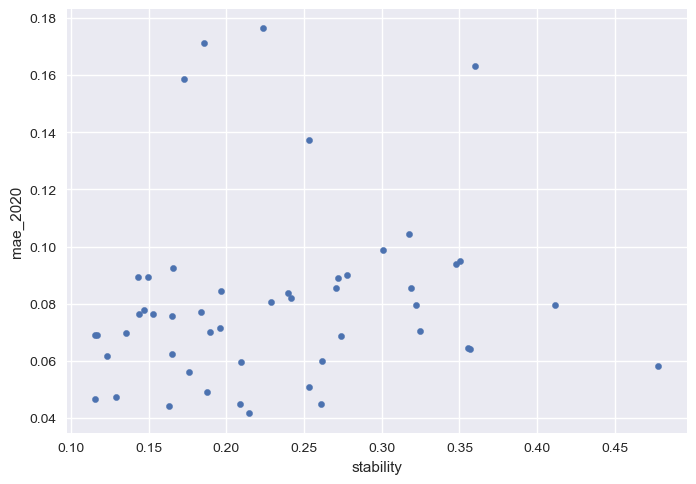

In [ ]:
all_metrics_df.plot.scatter(y="mae_2020", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse'>

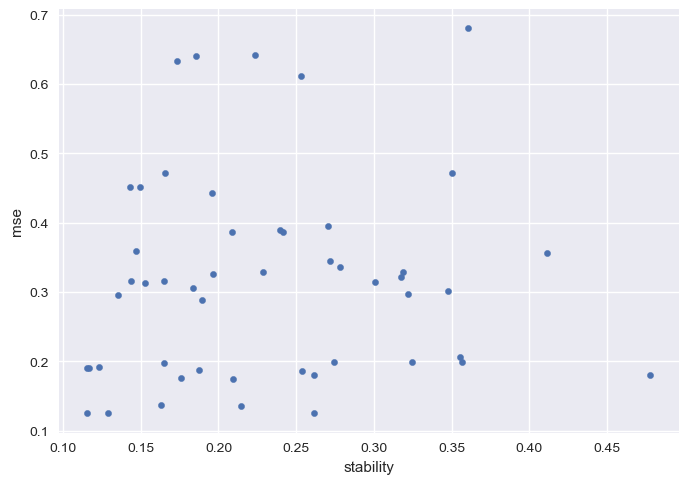

In [ ]:
all_metrics_df.plot.scatter(y="mse", x="stability")

<AxesSubplot:xlabel='stability', ylabel='mse_2020'>

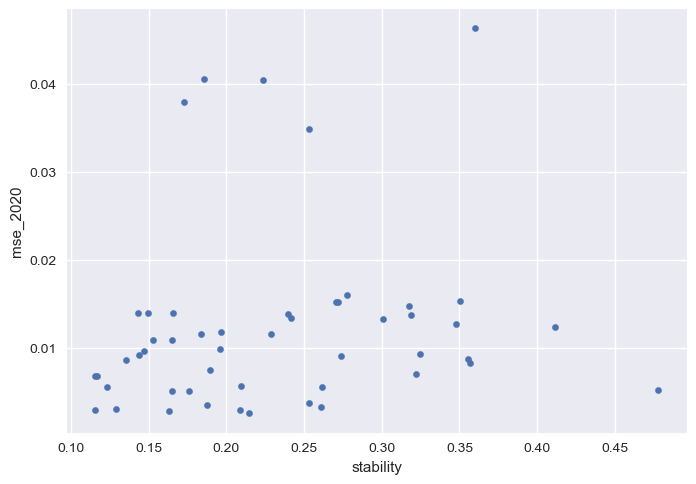

In [ ]:
all_metrics_df.plot.scatter(y="mse_2020", x="stability")